This notebook can be run on MP data only, as they already contain the formation energeis per atom. We did not calculate these for the experimental 3DCD data set. 

In [1]:
from data import DATA_3DCD, DATA_MP

In [2]:
%run ./modules.ipynb
sns.set(style="white", palette="muted", color_codes=True)
my_c = colors.ListedColormap(["mediumblue", "red"])
c = ["mediumblue", "red"]
sns.set_palette(sns.color_palette(c))

/root/anaconda3/envs/r4/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


LOADING FORMATION ENERGIES

In [3]:
from pathlib import Path

df = pd.read_csv(DATA_MP.data)
if not Path("../r4data").exists():
    """For the example data set, we reduce the energetic data like this:"""
    df = df[::100]

In [4]:
npzfile = np.load(DATA_MP.soap, allow_pickle=True)
for k in npzfile.files:
    print(k)
df["magic"] = npzfile["magic"]

idx
my_frames
magic
X_raw
coeff


Text(0.5, 0, 'Formation Energy per atom (eV)')

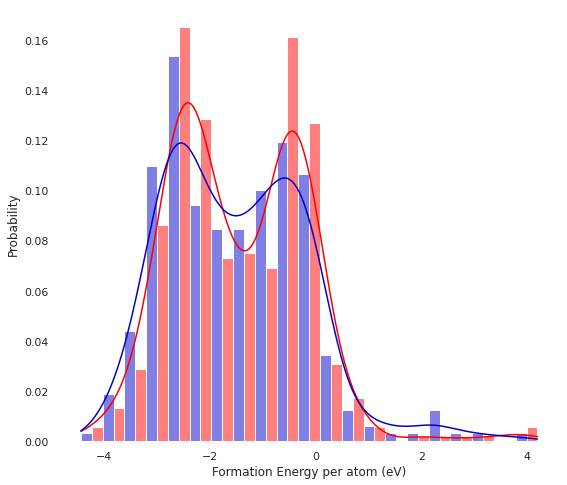

In [5]:
f, ax = plt.subplots(figsize=(9, 8))
sns.histplot(
    data=df,
    x="e_form",
    hue="magic",
    multiple="dodge",
    legend=False,
    common_norm=False,
    stat="probability",
    kde=True,
)
sns.despine(left=True, bottom=True)
plt.xlabel("Formation Energy per atom (eV)")

In [6]:
X_raw = npzfile["X_raw"]
y_raw = y_raw = np.array(df["e_form"]).reshape(-1, 1)
y_atom = npzfile["magic"]
my_frames = npzfile["my_frames"]

PRINCIPAL COVARIATES REGRESSION (PCovR) REPRESENTATION

In [7]:
i_train, i_test, X_train, X_test, y_train, y_test = train_test_split(
    np.arange(X_raw.shape[0]), X_raw, y_raw, train_size=0.8
)
print(f"Shape of testing data is: {X_train.shape}, ||X|| = {np.linalg.norm(X_train)}.")
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

print(
    "Norm of the features: %0.2f \nNorm of the targets: %0.2f"
    % (np.linalg.norm(X_raw), np.linalg.norm(y_raw))
)
x_scaler = StandardFlexibleScaler(column_wise=False).fit(X_raw)
y_scaler = StandardFlexibleScaler(column_wise=True).fit(y_raw)

# Center total dataset
X = x_scaler.transform(X_raw)
Y = y_scaler.transform(y_raw)

# Center training data
X_train = x_scaler.transform(X_train)
y_train = y_scaler.transform(y_train)

# Center training data
X_test = x_scaler.transform(X_test)
y_test = y_scaler.transform(y_test)

print("After normalization: ")
print(f"Shape of testing data is: {X_train.shape}, ||X|| = {np.linalg.norm(X_train)}.")
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

print(
    "Norm of the features: %0.2f \nNorm of the targets: %0.2f"
    % (np.linalg.norm(X_raw), np.linalg.norm(y_raw))
)

Shape of testing data is: (672, 2000), ||X|| = 0.07715840427863795.
(672, 2000) (168, 2000) (672, 1) (168, 1)
Norm of the features: 0.08 
Norm of the targets: 56.70
After normalization: 
Shape of testing data is: (672, 2000), ||X|| = 26.877949479060018.
(672, 2000) (168, 2000) (672, 1) (168, 1)
Norm of the features: 0.08 
Norm of the targets: 56.70


GRID CV REGRESSION

R^2 of training is  0.19610677614156347
R^2 of testing is  -0.08937377095836774
Best regularization is  1.0
RMSE on predicted quantity =  1.0924453889110157


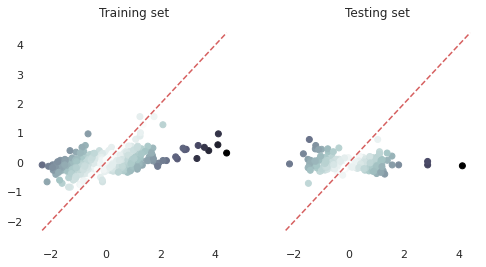

In [8]:
alphas = np.logspace(-0, -6, 30)
ridgecv = RidgeCV(cv=4, fit_intercept=False, alphas=alphas)
ridgecv.fit(X_train, y_train)
yp_test = ridgecv.predict(X_test)
yp_train = ridgecv.predict(X_train)
print("R^2 of training is ", ridgecv.score(X_train, y_train))
print("R^2 of testing is ", ridgecv.score(X_test, y_test))
print("Best regularization is ", ridgecv.alpha_)

fig, (ax_train, ax_test) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
ax_train.scatter(y_train, yp_train, c=np.abs(y_train - yp_train), cmap="bone_r")
ax_test.scatter(y_test, yp_test, c=np.abs(y_test - yp_test), cmap="bone_r")

bounds = (
    np.min((Y.min(), yp_train.min(), yp_test.min())),
    np.max((Y.max(), yp_train.max(), yp_test.max())),
)

ax_train.plot(bounds, bounds, "r--")
ax_train.set_title("Training set")
ax_test.set_title("Testing set")
ax_test.plot(bounds, bounds, "r--")
sns.despine(left=True, bottom=True)

print("RMSE on predicted quantity = ", mean_squared_error(y_test, yp_test))

HOW MIXING PARAMETER BETA (BETWEEN PCA AND REGRESSION) AFFECTS PCOVR

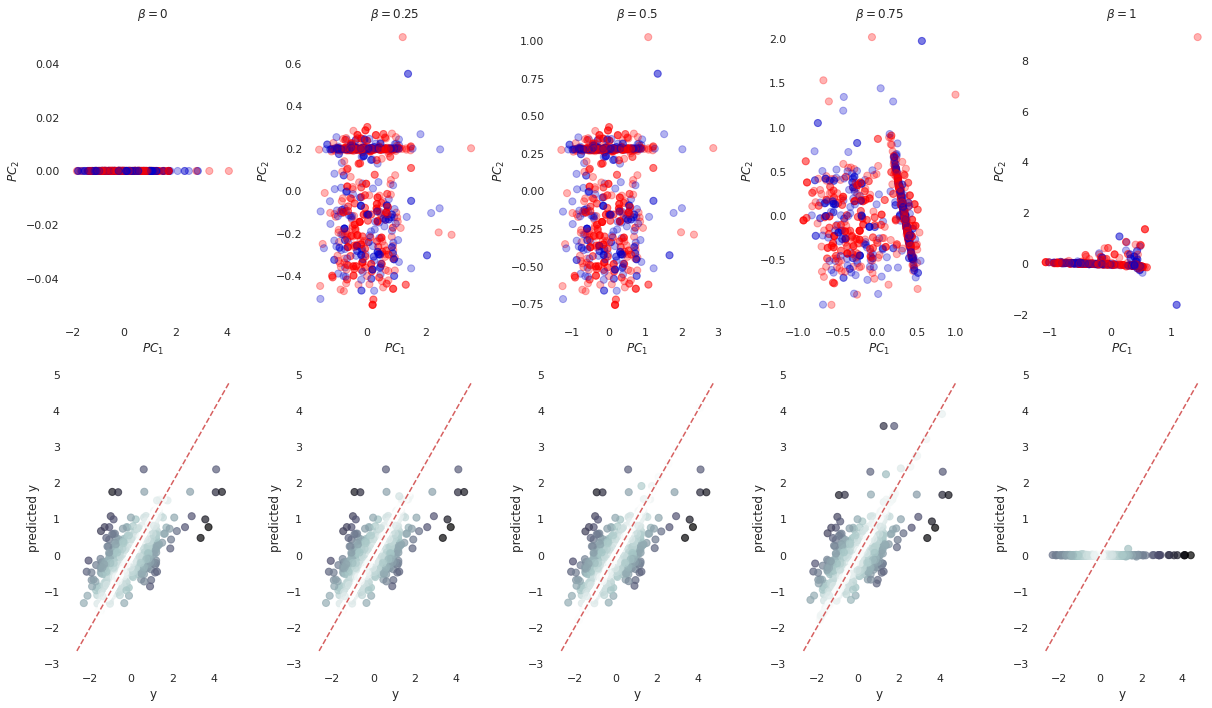

In [9]:
betas = [0, 0.25, 0.5, 0.75, 1]

fig, axes = plt.subplots(2, 5, figsize=(17, 10))
sns.despine(left=True, bottom=True)

for i in range(len(betas)):

    pcovr = PCovR(mixing=betas[i], n_components=2)
    pcovr.fit(X, Y)
    T = pcovr.transform(X)
    yp = pcovr.predict(X)

    axes[0, i].scatter(
        T[:, 0],
        T[:, 1],
        s=50,
        alpha=0.3,
        c=y_atom,
        cmap=colors.ListedColormap(["mediumblue", "red"]),
    )
    axes[0, i].set_xlabel(r"$PC_1$")
    axes[0, i].set_ylabel(r"$PC_2$")

    axes[1, i].scatter(Y, yp, s=50, alpha=0.7, c=np.abs(Y - yp), cmap="bone_r")
    axes[1, i].plot(axes[1, i].get_xlim(), axes[1, i].get_xlim(), "r--")
    axes[1, i].set_xlabel(r"y")
    axes[1, i].set_ylabel(r"predicted y")

    axes[0, i].set_title(r"$\beta=$" + str(betas[i]))
    fig.tight_layout()

ENERGY DESCRIPTORS 

In [10]:
df.head()
e_form = df["e_form"]
e_hull = df["e_hull"]
e_gap = df["gap pbe"]

Plotting the first two principal covariates of the Formation energy per atom (eV) (main paper)


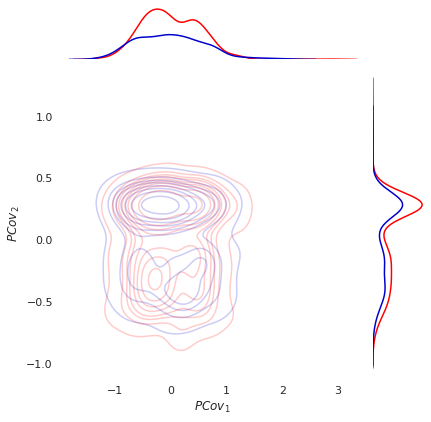

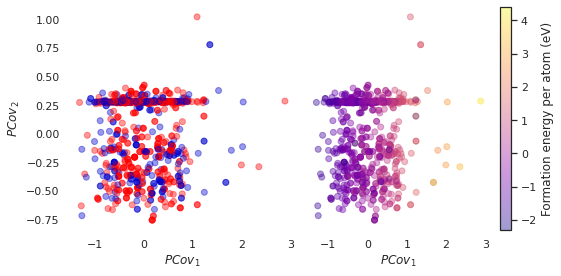

Plotting PCov1 against PCov2, PCov3, PCov4 for the Formation energy per atom (eV) (SI figures)


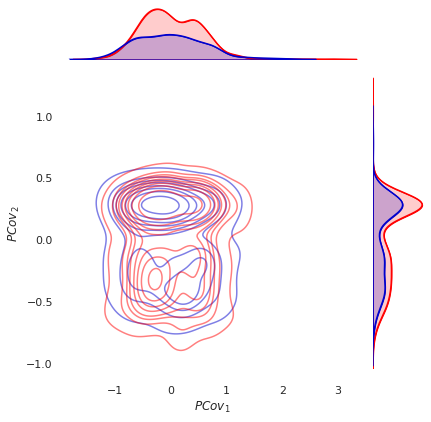

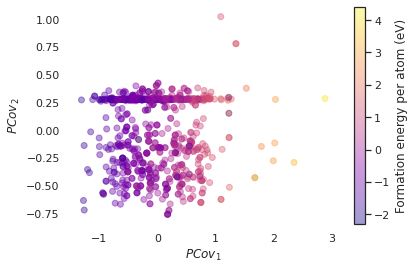

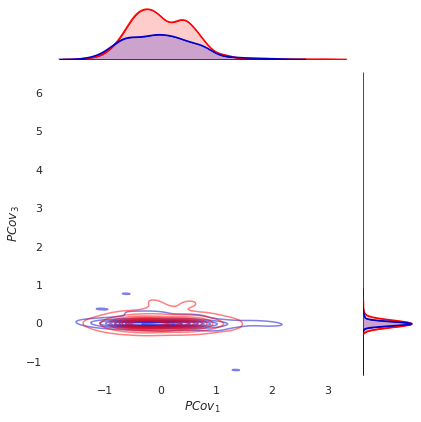

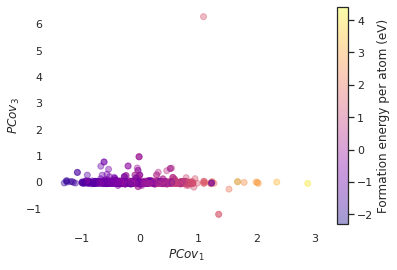

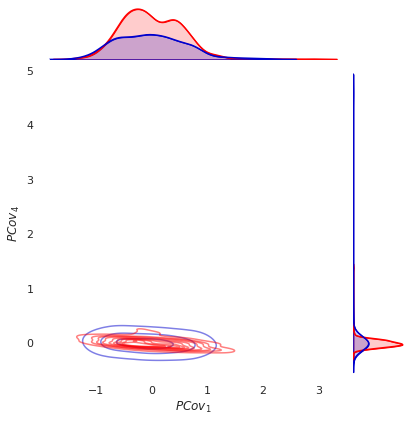

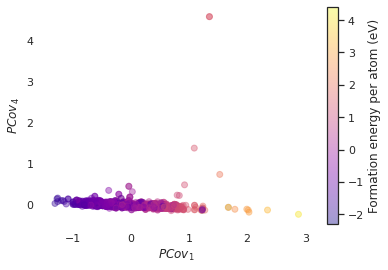

Plotting the first two principal covariates of the Energy above convex hull (eV) (main paper)


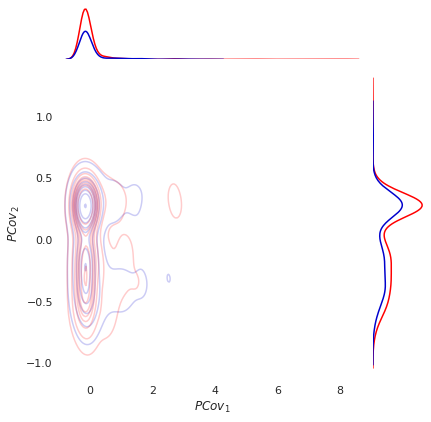

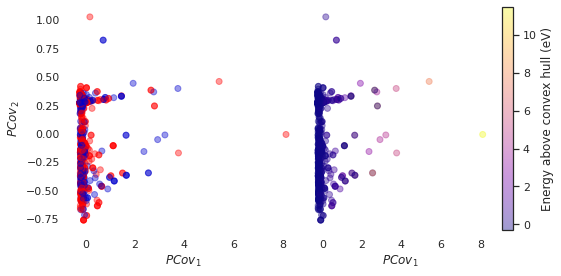

Plotting PCov1 against PCov2, PCov3, PCov4 for the Energy above convex hull (eV) (SI figures)


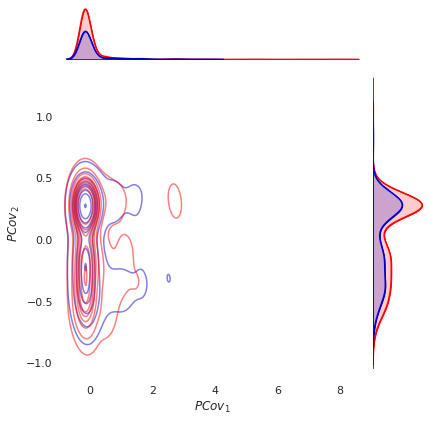

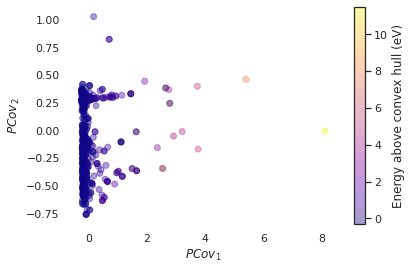

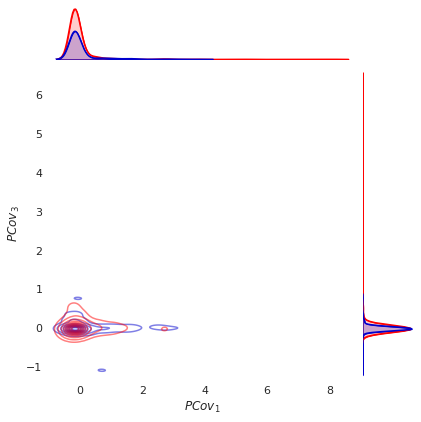

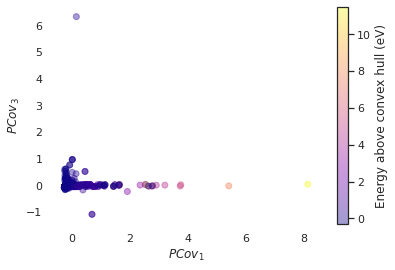

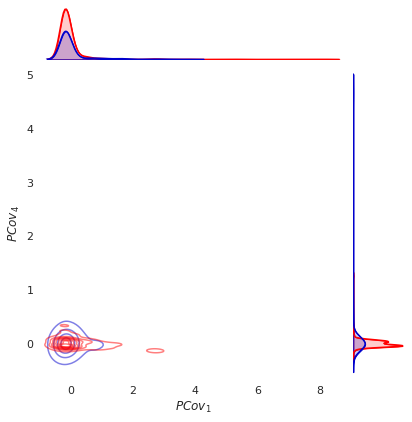

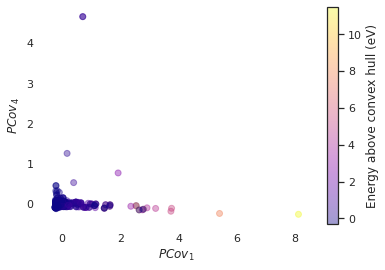

Plotting the first two principal covariates of the Band gab energy (eV) (main paper)


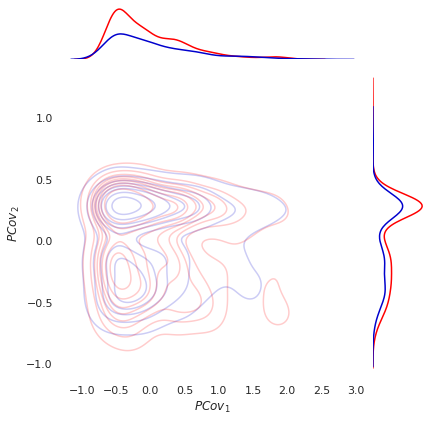

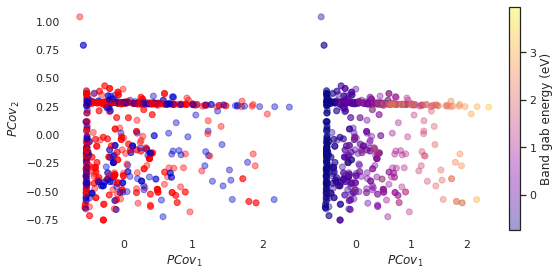

Plotting PCov1 against PCov2, PCov3, PCov4 for the Band gab energy (eV) (SI figures)


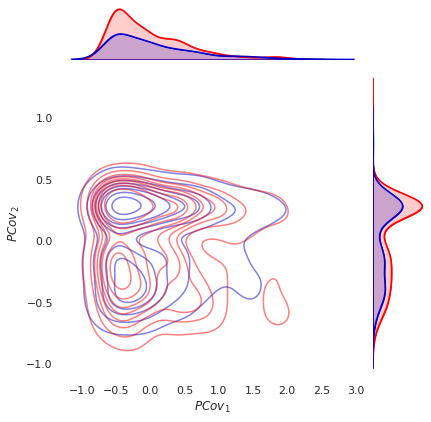

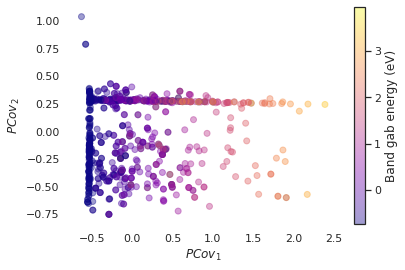

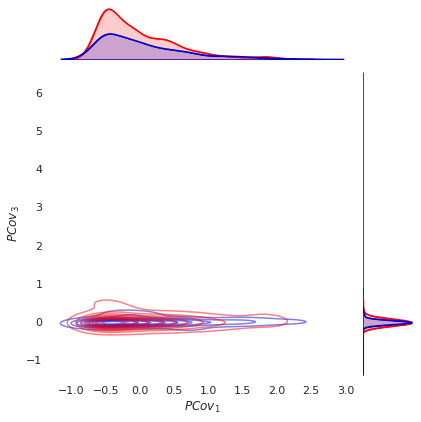

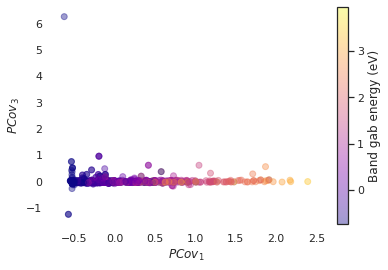

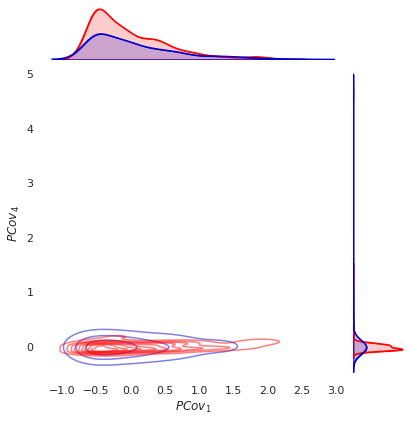

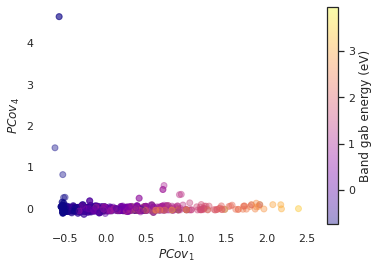

In [18]:
n_PC = 5  #  number of principal covariates
titles = [
    "Formation energy per atom (eV)",
    "Energy above convex hull (eV)",
    "Band gab energy (eV)",
]
quantity = [e_form, e_hull, e_gap]
for i in range(len(titles)):
    X = np.copy(X_raw)
    y_raw = np.array(quantity[i]).reshape(-1, 1)
    i_train, i_test, X_train, X_test, y_train, y_test = train_test_split(
        np.arange(X.shape[0]), X, y_raw, train_size=0.8
    )

    x_scaler = StandardFlexibleScaler(column_wise=False).fit(X)
    y_scaler = StandardFlexibleScaler(column_wise=True).fit(y_raw)

    # Center total dataset
    X = x_scaler.transform(X)
    Y = y_scaler.transform(y_raw)

    # Center training data
    X_train = x_scaler.transform(X_train)
    y_train = y_scaler.transform(y_train)

    # Center training data
    X_test = x_scaler.transform(X_test)
    y_test = y_scaler.transform(y_test)
    pcovr = PCovR(mixing=0.5, n_components=n_PC)
    pcovr.fit(X, Y)

    T = pcovr.transform(X)
    yp = pcovr.predict(X)

    ridgecv.fit(X_train, y_train)
    yp_test = ridgecv.predict(X_test)

    # LINE PLOT, main paper, Fig6 top
    print('Plotting the first two principal covariates of the '+titles[i]+' (main paper)')
    df = pd.DataFrame(T)
    g = sns.jointplot(
        data=df, x=df[0], y=df[1], hue=y_atom.ravel(), kind="kde", legend=False
    )
    g.set_axis_labels(r"$PCov_1$", r"$PCov_2$")
    fig.tight_layout()
    sns.despine(left=True, bottom=True)
    plt.show()
    plt.close()
    
    # SCATTER PLOTS, main paper, Fig6 bottom
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
    ax1.scatter(T[:, 0], T[:, 1], alpha=0.4, c=y_atom, cmap=my_c)
    g = ax2.scatter(T[:, 0], T[:, 1], alpha=0.4, c=Y, cmap="plasma")
    plt.colorbar(g, orientation="vertical", label=titles[i])
    ax1.set_xlabel(r"$PCov_1$")
    ax2.set_xlabel(r"$PCov_1$")
    ax1.set_ylabel(r"$PCov_2$")
    fig.tight_layout()
    sns.despine(left=True, bottom=True)
    plt.show()
    plt.close()
    
    print('Plotting PCov1 against PCov2, PCov3, PCov4 for the '+titles[i]+' (SI figures)')
    
    # LINE PLOT and SCATTER plot, in order, with 
    # PCOV1 against PCOV2, PCOV3, PCOV4 
    # for the three different energy descriptors
    for k in range(1,4):
        
        g = sns.jointplot(
        data=df, x=df[0], y=df[k], hue=y_atom.ravel(), kind="kde", alpha=.5, legend=False)
        g.plot_marginals(sns.kdeplot, color='b', shade=True, alpha=.2, legend=False)
        g.set_axis_labels(r"$PCov_1$", r"$PCov_"+str(k+1)+"$")
        fig.tight_layout()
        sns.despine(left=True, bottom=True)
        fig = g.fig
        plt.show()
        plt.close()
        
        f=plt.scatter(T[:, 0], T[:, k], alpha=0.4, c=Y, cmap="plasma")
        plt.colorbar(f, orientation="vertical", label=titles[i])
        plt.xlabel(r"$PCov_1$")
        plt.ylabel(r"$PCov_"+str(k+1)+"$")
        fig.tight_layout()
        sns.despine(left=True, bottom=True)
        plt.show()
        plt.close()

#     print("R^2 with PCovR= ", pcovr.score(X, Y))
#     print("R^2 of testing is with RidgeCV", ridgecv.score(X_test, y_test))
#     print("RMSE on predicted quantity = ", mean_squared_error(y_test, yp_test))
#     print(
#         "error in units (eV) of predicted quantity before scaling = ",
#         (max(y_raw) - min(y_raw)) * (1 - ridgecv.score(X_test, y_test)),
#     )
#     print(
#         "error in units (eV) of predicted quantity after scaling= ",
#         (max(Y) - min(Y)) * (1 - ridgecv.score(X_test, y_test)),
#     )

    plt.show()
    plt.close()